In [112]:
import numpy as np
import json
from collections import defaultdict, Counter
from scipy import spatial, stats
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import datetime as dt

In [113]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'
AGG_EMBED_PATH = LOGS + 'semantics_mano/agg_embed/'

## Inspecting individual words

Note that the axes in the wrong direction, e.g. all positive values mean the word leans more towards the opposite of the synset name, while move negative means it is more related to the synset name. This is why "soured" shows up as a prominent positive axis for "sweet girl", etc. 

In [956]:
with open(LOGS + 'semantics_mano/results/scores.json', 'r') as infile: 
    scores = json.load(infile) 

vocab_order = []
with open(LOGS + 'semantics_mano/results/vocab_order.txt', 'r') as infile:
    vocab_order = infile.readlines()

with open(LOGS + 'coref_results/mano_gender_labels.json', 'r') as infile: 
    gender_labels = json.load(infile)

In [957]:
word_poles = defaultdict(Counter) # {word : {pole : score}}
for pole in scores: 
    s = scores[pole]
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        word_poles[term][pole] = s[i]

In [9]:
print(word_poles['alpha'].most_common()[:10])
print(word_poles['alpha'].most_common()[-10:])

[('covered.a.01', 0.25558773434051607), ('clothed.a.01', 0.20460857317052156), ('affected.a.01', 0.19743399192574534), ('busy.a.01', 0.19340250274625598), ('heavy.a.01', 0.1636908153666239), ('mature.a.01', 0.16354657637493), ('androgynous.a.02', 0.15458037457221652), ('delicate.a.01', 0.15350429755099337), ('experienced.a.01', 0.14051773941321305), ('limited.a.01', 0.14049881094011013)]
[('thick.a.01', -0.15037315269704593), ('right.a.04', -0.1534961767732639), ('upland.a.01', -0.15577203865108905), ('capitalistic.a.01', -0.16656310684758813), ('reasonable.a.01', -0.17066723676667722), ('enthusiastic.a.01', -0.17872971894421674), ('optimistic.a.01', -0.182795450552113), ('fat.a.01', -0.2067701379119683), ('moral.a.01', -0.2303085749221428), ('assertive.a.01', -0.26428843033663973)]


In [10]:
print(word_poles['beta'].most_common()[:10])
print(word_poles['beta'].most_common()[-10:])

[('clothed.a.01', 0.2302962468802881), ('busy.a.01', 0.22930095475453216), ('covered.a.01', 0.219025675618927), ('heavy.a.01', 0.20749793146852147), ('experienced.a.01', 0.20338786825387173), ('affected.a.01', 0.18867313060161872), ('active.a.03', 0.17924688026636332), ('visible.a.01', 0.17472462286340498), ('heavy.a.04', 0.16004797618931815), ('stressed.a.02', 0.15305906321978352)]
[('harmless.a.01', -0.1537984253997058), ('auspicious.a.01', -0.15603754767041586), ('quiet.a.02', -0.15667051373894447), ('capitalistic.a.01', -0.15725929069852884), ('defiant.a.01', -0.16001385997621265), ('assertive.a.01', -0.16640615169659442), ('pleasing.a.01', -0.17419947414924292), ('reasonable.a.01', -0.19200510196082082), ('moral.a.01', -0.19343655301123647), ('optimistic.a.01', -0.20350268094208734)]


In [11]:
print(word_poles['escort'].most_common()[:10])
print(word_poles['escort'].most_common()[-10:])

[('visible.a.01', 0.22309017709915227), ('tough.a.01', 0.213360012645474), ('settled.a.02', 0.19296624720667427), ('used.a.01', 0.1857999460473453), ('inclined.a.02', 0.1457751942450308), ('genuine.a.01', 0.144264839289096), ('heavy.a.04', 0.13563279490208444), ('mature.a.01', 0.12739001348117515), ('mindful.a.01', 0.12420469830860567), ('definite.a.01', 0.12353489816582765)]
[('enchanted.a.01', -0.1297488955033736), ('smooth.a.01', -0.13000566120988905), ('serviceable.a.01', -0.1453235611522138), ('east.a.01', -0.15217072046089813), ('assertive.a.01', -0.1561224887165856), ('optimistic.a.01', -0.1587276536999621), ('foreign.a.02', -0.16007725646172424), ('blond.a.01', -0.16609265606499185), ('enthusiastic.a.01', -0.17101999786777775), ('vertical.a.01', -0.1960913578840736)]


In [12]:
print(word_poles['wife'].most_common()[:10])
print(word_poles['wife'].most_common()[-10:])

[('stressed.a.02', 0.1642349879986019), ('communicative.a.02', 0.1548538037300795), ('shod.a.01', 0.1543340554310427), ('inclined.a.02', 0.147667724371479), ('used.a.01', 0.11680373567631179), ('nascent.a.01', 0.11622444489836678), ('practical.a.01', 0.11315294289782041), ('clothed.a.01', 0.11043103649144768), ('androgynous.a.02', 0.1101759594250323), ('worthy.a.01', 0.10829729959320025)]
[('prejudiced.a.02', -0.11483809209471618), ('refined.a.01', -0.11657568793466172), ('rural.a.01', -0.12230937551930993), ('sincere.a.01', -0.1348905506471321), ('enthusiastic.a.01', -0.14627547671047186), ('pleasing.a.01', -0.1476187306605714), ('vertical.a.01', -0.1505769589603431), ('indulgent.a.01', -0.17271745348962464), ('womanly.a.01', -0.2510947708161832), ('blond.a.01', -0.26228053180066013)]


In [13]:
print(word_poles['celebrities'].most_common()[:10])
print(word_poles['celebrities'].most_common()[-10:])

[('tough.a.01', 0.17081688060138467), ('heavy.a.04', 0.16985555976159045), ('shod.a.01', 0.16921350151419515), ('formal.a.01', 0.16257934295405002), ('rational.a.01', 0.1539584724003656), ('clearheaded.a.01', 0.15095418273110356), ('practical.a.01', 0.14949227852479552), ('used.a.01', 0.13713366262867435), ('functional.a.01', 0.13655726047751593), ('live.a.01', 0.13282821636469758)]
[('publicized.a.01', -0.16861678299034474), ('indulgent.a.01', -0.1689884056297398), ('fashionable.a.01', -0.17495802324450085), ('assertive.a.01', -0.1790488263955755), ('blond.a.01', -0.18400036903294198), ('honorable.a.02', -0.19386016991548416), ('capitalistic.a.01', -0.20089025110473818), ('enchanted.a.01', -0.2038839316617339), ('optimistic.a.01', -0.219878418645344), ('enthusiastic.a.01', -0.2702015404193948)]


In [14]:
print(word_poles['princes'].most_common()[:10])
print(word_poles['princes'].most_common()[-10:])

[('tough.a.01', 0.1805231952555273), ('present.a.01', 0.16453077107531805), ('modern.a.01', 0.1598416223346724), ('tough.a.03', 0.1524890905554785), ('used.a.01', 0.1516182763602973), ('surface.a.01', 0.1467284602966408), ('androgynous.a.02', 0.14105737420570597), ('shod.a.01', 0.13003690030581358), ('empirical.a.01', 0.12563998245363733), ('settled.a.02', 0.11645714677201925)]
[('refined.a.01', -0.15650710977105559), ('moral.a.01', -0.1566110449753308), ('glorious.a.01', -0.15852079714472445), ('assertive.a.01', -0.17072084941067336), ('rhetorical.a.02', -0.1747360461794557), ('honorable.a.02', -0.17498177536861484), ('auspicious.a.01', -0.1800081524016834), ('gracious.a.01', -0.190434756294191), ('pleasing.a.01', -0.19060802410015823), ('noble.a.02', -0.43068912052829506)]


In [15]:
print(word_poles['normies'].most_common()[:10])
print(word_poles['normies'].most_common()[-10:])

[('fragrant.a.01', 0.23376121381115872), ('clean.a.01', 0.23125052308491592), ('superior.a.01', 0.22022119417854905), ('educated.a.01', 0.21966800373108855), ('mindful.a.01', 0.2182822500174266), ('busy.a.01', 0.21826220544904631), ('settled.a.02', 0.21495180240785697), ('modest.a.01', 0.21196934804280826), ('careful.a.01', 0.20642503539056628), ('humorous.a.01', 0.20533699336294906)]
[('nonproprietary.a.01', -0.12804204739587602), ('wet.a.01', -0.13109088872897956), ('proud.a.01', -0.14986895208471712), ('moral.a.01', -0.1507341828212458), ('simple.a.01', -0.15215763433495405), ('conscious.a.02', -0.15456060351936168), ('prejudiced.a.02', -0.1595962284843616), ('selfish.a.01', -0.2134563069472661), ('ordinary.a.01', -0.23051900162149913), ('fat.a.01', -0.23554981095825875)]


In [16]:
print(word_poles['simps'].most_common()[:10])
print(word_poles['simps'].most_common()[-10:])

[('clean.a.01', 0.2604844388082124), ('serious.a.01', 0.2527842823082931), ('definite.a.01', 0.24164403889662878), ('conventional.a.04', 0.23772145187427085), ('abstemious.a.01', 0.22977715695462214), ('careful.a.01', 0.216644847990057), ('gracious.a.01', 0.21475233326039692), ('cautious.a.01', 0.21308335759125957), ('tasteful.a.01', 0.2048277942128987), ('busy.a.01', 0.20080071600078564)]
[('cheerful.a.01', -0.13711930530631397), ('flexible.a.02', -0.13992376426055217), ('quiet.a.01', -0.14082034815067648), ('flexible.a.01', -0.1432322652076855), ('nonproprietary.a.01', -0.1515342433042608), ('changeable.a.02', -0.15319182252356459), ('indulgent.a.01', -0.16091865765036034), ('simple.a.01', -0.17922892126620177), ('proud.a.01', -0.216327865672561), ('fat.a.01', -0.281288708181036)]


In [17]:
print(word_poles['prostitute'].most_common()[:10])
print(word_poles['prostitute'].most_common()[-10:])

[('used.a.01', 0.2738366691962819), ('clothed.a.01', 0.23937097872188579), ('settled.a.02', 0.2291109180309099), ('genuine.a.01', 0.20774164855996033), ('reputable.a.01', 0.2034176074242275), ('free.a.01', 0.20046270103216252), ('safe.a.01', 0.19728634455816058), ('superior.a.01', 0.18511084056671884), ('visible.a.01', 0.18354977985627313), ('careful.a.01', 0.1824616231531639)]
[('assertive.a.01', -0.1599361735706449), ('capitalistic.a.01', -0.16414326236623333), ('tired.a.01', -0.17383875787119737), ('optimistic.a.01', -0.17687235032425183), ('commercial.a.01', -0.18044915161152808), ('corrupt.a.01', -0.18965010845156033), ('womanly.a.01', -0.19693576109523947), ('blond.a.01', -0.1993103340935537), ('indulgent.a.01', -0.21088796861255577), ('prejudiced.a.02', -0.26173099058036536)]


In [18]:
print(word_poles['sweet girl'].most_common()[:10])
print(word_poles['sweet girl'].most_common()[-10:])

[('soured.a.01', 0.2993762680324553), ('old.a.01', 0.24585196920696173), ('large.a.01', 0.23454624090201942), ('demanding.a.01', 0.20686306185232417), ('busy.a.01', 0.197643275722586), ('distant.a.02', 0.189853979436521), ('used.a.01', 0.18674327001249796), ('tough.a.03', 0.1843033060276611), ('much.a.01', 0.1842825865919937), ('cursed.a.01', 0.17506098967106104)]
[('reasonable.a.01', -0.20029725604609822), ('sympathetic.a.04', -0.20576029865844586), ('exculpatory.a.01', -0.2085969624311667), ('refined.a.01', -0.22853918654971514), ('beautiful.a.01', -0.23545727870178343), ('sincere.a.01', -0.2519843280077457), ('optimistic.a.01', -0.2563437773193954), ('pleasing.a.01', -0.2725066810670002), ('kind.a.01', -0.2763736927813124), ('lovable.a.01', -0.3158886668571521)]


In [19]:
print(word_poles['thot'].most_common()[:10])
print(word_poles['thot'].most_common()[-10:])

[('definite.a.01', 0.1942506848860781), ('clean.a.01', 0.1673035189706998), ('improved.a.01', 0.16144572589832623), ('motivated.a.01', 0.152628178859815), ('conventional.a.04', 0.14834912226141417), ('assisted.a.01', 0.14402170982564783), ('gracious.a.01', 0.14375817406252167), ('exempt.a.01', 0.1386175631587233), ('meaningful.a.01', 0.1376077435672449), ('stable.a.01', 0.13545902803716559)]
[('strange.a.01', -0.10258656068959875), ('flexible.a.02', -0.10486797902865443), ('satisfactory.a.01', -0.11070000339932176), ('thinkable.a.01', -0.11700241756682321), ('credulous.a.01', -0.12267252067925646), ('fat.a.01', -0.12638101965574716), ('nonproprietary.a.01', -0.12937259858528127), ('old.a.02', -0.13903732562136084), ('same.a.01', -0.15038574864936355), ('distant.a.01', -0.20976531914767527)]


In [1087]:
print(word_poles['women'].most_common()[:10])
print(word_poles['women'].most_common()[-10:])

[('stressed.a.02', 0.2689686041765973), ('androgynous.a.02', 0.26615011162215274), ('used.a.01', 0.17418508989923898), ('shod.a.01', 0.17415410665801528), ('heavy.a.04', 0.15623034942651035), ('clothed.a.01', 0.14830480731774676), ('worthy.a.01', 0.14272245389365118), ('resolute.a.01', 0.13329823016528006), ('sacred.a.01', 0.13287332282955855), ('protected.a.01', 0.12342149919623766)]
[('selfish.a.01', -0.12718445486502283), ('capitalistic.a.01', -0.12951324600671643), ('hot.a.03', -0.1325397538418296), ('graceful.a.01', -0.1355055651284687), ('pleasing.a.01', -0.13815785044580048), ('indulgent.a.01', -0.17790987421169782), ('shapely.a.01', -0.18686821149604158), ('prejudiced.a.02', -0.2406379872123752), ('blond.a.01', -0.32147493747143213), ('womanly.a.01', -0.5140653893774207)]


In [1072]:
print(word_poles['feminists'].most_common()[:10])
print(word_poles['feminists'].most_common()[-10:])

[('polite.a.01', 0.17985841197950814), ('modest.a.01', 0.17653803588784295), ('used.a.01', 0.1715678457289098), ('valuable.a.01', 0.16322167051551079), ('nice.a.01', 0.15836866429308205), ('emotional.a.02', 0.1491505235538392), ('additive.a.02', 0.13107291486697675), ('liked.a.01', 0.12888404120794), ('mindful.a.01', 0.12706343765144104), ('neutral.a.04', 0.12603565566086072)]
[('frequent.a.01', -0.15548430454238432), ('moral.a.01', -0.15607597896407613), ('active.a.03', -0.17925300951197784), ('common.a.02', -0.18319777932765552), ('selfish.a.01', -0.19129833557389125), ('humane.a.02', -0.2077279418444939), ('blond.a.01', -0.21246622698158413), ('national.a.02', -0.2433044135341358), ('prejudiced.a.02', -0.24611701336332895), ('womanly.a.01', -0.32897758997938087)]


# Variance within gender

In [958]:
fem_variance = Counter() # {pole: variance of fem terms}
fem_extremes = defaultdict(tuple) # {pole: (top N terms, bottom N terms)}
masc_variance = Counter() 
masc_extremes = defaultdict(tuple)
fem_scores = defaultdict(list) # {pole: scores in order of x_words}
masc_scores = defaultdict(list) # {pole: scores in order of y_words}
N = 3
for pole in scores: 
    s = scores[pole]
    x = [] # fem scores
    x_words = []
    y = [] # masc scores
    y_words = []
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        if term in gender_labels: 
            if gender_labels[term] > 0.75: 
                x.append(s[i])
                x_words.append(term)
            elif gender_labels[term] < 0.25: 
                y.append(s[i])
                y_words.append(term)
    fem_variance[pole] = np.var(x)
    indices = np.argpartition(x, -N)[-N:]
    topN = [x_words[idx].strip() for idx in indices]
    indices = np.argpartition(x, N)[:N]
    bottomN = [x_words[idx].strip() for idx in indices]
    fem_extremes[pole] = (topN, bottomN, min(x), max(x))
    fem_scores[pole] = x
    
    masc_variance[pole] = np.var(y)
    indices = np.argpartition(y, -N)[-N:]
    topN = [y_words[idx].strip() for idx in indices]
    indices = np.argpartition(y, N)[:N]
    bottomN = [y_words[idx].strip() for idx in indices]
    masc_extremes[pole] = (topN, bottomN, min(y), max(y))
    masc_scores[pole] = y

In [959]:
for tup in fem_variance.most_common(20): 
    print(tup)
    pole = tup[0]
    topN, bottomN, mi, ma = fem_extremes[pole]
    print("TOP:", topN)
    print("BOTTOM:", bottomN)
    print(mi, ma)
    print()

('womanly.a.01', 0.02077747910939835)
TOP: ['hambeast', 'tomboys', 'tomboy']
BOTTOM: ['female gender', 'feminine women', 'feminine woman']
-0.5856429849438389 0.36751912466938597

('androgynous.a.02', 0.010502650921013617)
TOP: ['white females', 'female', 'females']
BOTTOM: ['noodlewhore', 'nympho', 'manipulative bitch']
-0.19918680740902128 0.4108695695846027

('lovable.a.01', 0.010148572488842763)
TOP: ['stupid cunts', 'degenerate whores', 'accusers']
BOTTOM: ['sweet girl', 'little princess', 'beautiful girl']
-0.3158886668571521 0.4004010633757613

('reputable.a.01', 0.008494069503982132)
TOP: ['slut', 'dirty slut', 'sluts']
BOTTOM: ['great wife', 'great woman', 'great women']
-0.14964813563467744 0.4022180094944489

('wholesome.a.01', 0.008359628369444415)
TOP: ['evil bitch', 'dirty slut', 'degenerate whores']
BOTTOM: ['homemakers', 'healthy woman', 'healthy women']
-0.24472081446745786 0.3657217434203625

('clean.a.01', 0.007791131661771394)
TOP: ['club sluts', 'hambeasts', 'harlo

In [960]:
for tup in masc_variance.most_common(20): 
    print(tup)
    pole = tup[0]
    topN, bottomN, mi, ma = masc_extremes[pole]
    print("TOP:", topN)
    print("BOTTOM:", bottomN)
    print(mi, ma)
    print()

('androgynous.a.02', 0.012172077654613742)
TOP: ['dominant males', 'male', 'males']
BOTTOM: ['hypocrite', 'hypocrites', 'manipulator']
-0.2604874475023576 0.44170802824635863

('womanly.a.01', 0.011065397100844964)
TOP: ['wimp', 'wanker', 'goober']
BOTTOM: ['feminine men', 'male gender', 'male feminist']
-0.5029534793157493 0.29910455279596726

('reputable.a.01', 0.009933447140099574)
TOP: ['misogynists', 'misogynist', 'wimp']
BOTTOM: ['great men', 'great people', 'great leader']
-0.22716405597214687 0.3987890193065139

('lovable.a.01', 0.009641551859002513)
TOP: ['hater', 'traitors', 'haters']
BOTTOM: ['little angel', 'sweet guy', 'beautiful man']
-0.2916932595371912 0.3965976053049023

('wholesome.a.01', 0.009306402618719354)
TOP: ['fucking hypocrite', 'fucking hypocrites', 'buffoon']
BOTTOM: ['healthy man', 'healthy male', 'healthy men']
-0.24359662484688357 0.3695135063377389

('intellectual.a.02', 0.008602826173350104)
TOP: ['circumcised man', 'hypocrite', 'uncircumcised men']
BOT

## Axes similarities for each clusters' highly gendered terms

In [961]:
with open(LOGS + 'gram_counts/combined_catyear_word_count.json', 'r') as infile: 
    catyear_word_count = json.load(infile)
total_vocab_count = Counter() # {term : count in mano reddit + forum}
for catyear in catyear_word_count: 
    for term in catyear_word_count[catyear]: 
        total_vocab_count[term] += catyear_word_count[catyear][term]
# remove bigram counts from unigrams 
for term in total_vocab_count: 
    if ' ' in term: 
        toks = term.split(' ')
        if toks[0] in total_vocab_count: 
            total_vocab_count[toks[0]] = total_vocab_count[toks[0]] - total_vocab_count[term]
        if toks[1] in total_vocab_count: 
            total_vocab_count[toks[1]] = total_vocab_count[toks[1]] - total_vocab_count[term]
print(total_vocab_count.most_common(20))

[('she', 1760546), ('he', 861007), ('women', 801795), ('man', 604788), ('people', 555328), ('girl', 490864), ('woman', 482506), ('someone', 458890), ('guys', 361499), ('guy', 344341), ('men', 336551), ('girls', 326322), ('anyone', 324551), ('friends', 243747), ('everyone', 238800), ('friend', 228233), ('others', 203092), ('female', 178923), ('person', 174827), ('you guys', 167224)]


In [962]:
with open(LOGS + 'time_series/cluster_members_6.json', 'r') as infile: 
    clust_words = json.load(infile)
clust_words_rev = {}
for clust in clust_words: 
    cluster_words = clust_words[clust]
    for w in cluster_words: 
        clust_words_rev[w] = clust

In [963]:
fem_axes = ['beautiful.a.01', 'lovable.a.01', 'clean.a.01']
masc_axes = ['beautiful.a.01', 'lovable.a.01', 'intellectual.a.02']

### New visualization plan

scatter plot for each axis, x-axis is overall frequency of word, y-axis is score, hue is the cluster number

In [69]:
cluster_order = [4, 3, 5, 1, 2, 0]

In [964]:
d = {
    'pole': [], 
    'gender': [],
    'clust_num': [], 
    'word': [], 
    'score': [],
    'frequency': [],
}
for clust_num in cluster_order: 
    for gender in ['fem', 'masc']:
        key = str(clust_num) + '_' + gender
        if gender == 'fem': 
            this_axes = fem_axes
        if gender == 'masc': 
            this_axes = masc_axes
        for pole in this_axes:  
            s = scores[pole]
            for i, term in enumerate(vocab_order): 
                term = term.strip()
                if str(clust_words_rev[term]) != str(clust_num): continue
                if term not in gender_labels: continue
                if gender == 'fem' and gender_labels[term] > 0.75: 
                    d['pole'].append(pole)
                    d['gender'].append(gender)
                    d['clust_num'].append(clust_num)
                    d['word'].append(term)
                    d['score'].append(s[i])
                    d['frequency'].append(total_vocab_count[term])
                if gender == 'masc' and gender_labels[term] < 0.25: 
                    d['pole'].append(pole)
                    d['gender'].append(gender)
                    d['clust_num'].append(clust_num)
                    d['word'].append(term)
                    d['score'].append(s[i])
                    d['frequency'].append(total_vocab_count[term])

In [965]:
cluster_score_df = pd.DataFrame.from_dict(d)
cluster_score_df['log_freq'] = cluster_score_df['frequency'].apply(lambda x: math.log10(x))
clust_num_letter_map = {4 : 'A', 3 : 'B', 5 : 'C', 1 : 'D', 2 : 'E', 0 : 'F'}
cluster_score_df['clust_letter'] = cluster_score_df['clust_num'].apply(lambda x: clust_num_letter_map[x])
cluster_score_df

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter
0,beautiful.a.01,fem,4,1 female,0.036255,700,2.845098,A
1,beautiful.a.01,fem,4,10 women,-0.002096,2914,3.464490,A
2,beautiful.a.01,fem,4,100 girls,-0.062551,1723,3.236285,A
3,beautiful.a.01,fem,4,15 women,0.029945,426,2.629410,A
4,beautiful.a.01,fem,4,2 women,0.016124,2053,3.312389,A
...,...,...,...,...,...,...,...,...
10756,intellectual.a.02,masc,0,virgin men,0.063220,892,2.950365,F
10757,intellectual.a.02,masc,0,white chad,-0.040579,2223,3.346939,F
10758,intellectual.a.02,masc,0,white chads,0.038740,878,2.943495,F
10759,intellectual.a.02,masc,0,white incel,0.137710,580,2.763428,F


In [966]:
this_df = cluster_score_df[cluster_score_df['clust_letter'] == 'F']
this_df = this_df[this_df['gender'] == 'masc']
print(set(this_df['word'].to_list()))

{'male incels', 'male virgin', 'real incel', 'gigachads', 'niceguys', 'white chads', 'gymcels', 'manlets', 'undesirable men', 'ethnic men', 'ugly manlet', 'ugly dudes', 'blackcels', 'virgin men', 'ricecel', 'school shooter', 'unattractive men', 'ugly incel', 'one chad', 'fellow incels', 'chad friends', 'normans', 'currycels', 'tradcuck', 'lonely men', 'true incels', 'white incel', 'failed normie', 'soy boy', 'other incels', 'neets', 'next chad', 'autist', 'incels', 'damn bro', 'content creators', 'more chads', 'chaddam', 'neet', 'bluepilled cuck', 'ugly man', 'many incels', 'incel', 'ugly incels', 'virgin male', 'ugly males', 'norman', 'blackcel', 'most chads', 'tradcucks', 'fakecels', 'chadlite', 'turbo manlet', 'true incel', 'chang', 'janitor', 'oldcel', 'bluepilled cucks', 'nigga', 'currycel', 'white incels', 'ugly people', 'husbank', 'soyboy', 'male virgins', 'ricecels', 'average incel', 'mentalcels', 'chadcel', 'norwood reaper', 'virgin loser', 'fucking incel', 'inferior men', 'mo

In [967]:
cluster_score_df[cluster_score_df['word'] == 'women']

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter
5827,beautiful.a.01,fem,1,women,-0.036429,801795,5.904063,D
6169,lovable.a.01,fem,1,women,-0.065459,801795,5.904063,D
6511,clean.a.01,fem,1,women,-0.002982,801795,5.904063,D


In [968]:
cluster_score_df[cluster_score_df['word'] == 'girls']

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter
2691,beautiful.a.01,fem,3,girls,-0.095671,326322,5.513646,B
3010,lovable.a.01,fem,3,girls,-0.130053,326322,5.513646,B
3329,clean.a.01,fem,3,girls,0.061343,326322,5.513646,B


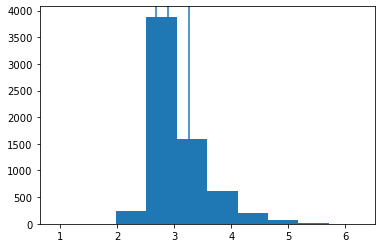

In [969]:
frequencies = [math.log10(i) for i in total_vocab_count.values()]
first_cutoff = np.percentile(frequencies, 1/4*100)
second_cutoff = np.percentile(frequencies, 2/4*100)
third_cutoff = np.percentile(frequencies, 3/4*100)
plt.hist(frequencies)
plt.axvline(first_cutoff)
plt.axvline(second_cutoff)
plt.axvline(third_cutoff)
plt.show()

In [970]:
def get_freq_bucket(x): 
    if x <= third_cutoff:
        return 'bottom 75%'
    else: 
        return 'top 25%'
cluster_score_df['freq_bucket'] = cluster_score_df['log_freq'].apply(get_freq_bucket)
cluster_score_df

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter,freq_bucket
0,beautiful.a.01,fem,4,1 female,0.036255,700,2.845098,A,bottom 75%
1,beautiful.a.01,fem,4,10 women,-0.002096,2914,3.464490,A,top 25%
2,beautiful.a.01,fem,4,100 girls,-0.062551,1723,3.236285,A,bottom 75%
3,beautiful.a.01,fem,4,15 women,0.029945,426,2.629410,A,bottom 75%
4,beautiful.a.01,fem,4,2 women,0.016124,2053,3.312389,A,top 25%
...,...,...,...,...,...,...,...,...,...
10756,intellectual.a.02,masc,0,virgin men,0.063220,892,2.950365,F,bottom 75%
10757,intellectual.a.02,masc,0,white chad,-0.040579,2223,3.346939,F,top 25%
10758,intellectual.a.02,masc,0,white chads,0.038740,878,2.943495,F,bottom 75%
10759,intellectual.a.02,masc,0,white incel,0.137710,580,2.763428,F,bottom 75%


In [971]:
fem_cluster_score_df = cluster_score_df[cluster_score_df['gender'] == 'fem']
masc_cluster_score_df = cluster_score_df[cluster_score_df['gender'] == 'masc']

In [122]:
def reindex_df(df, weight_col):
    """expand the dataframe to prepare for resampling
    result is 1 row per count per sample"""
    df = df.reindex(df.index.repeat(df[weight_col]))
    df.reset_index(drop=True, inplace=True)
    return(df)
cluster_order_str = [str(x) for x in cluster_order]
pole_titles = {'beautiful.a.01' : 'beautiful $\leftrightarrow$ ugly',
               'lovable.a.01' : 'lovable $\leftrightarrow$ detestable', 
               'prejudiced.a.02': 'prejudiced $\leftrightarrow$ unprejudiced', 
               'old.a.01': 'old $\leftrightarrow$ young', 
               'clean.a.01': 'clean $\leftrightarrow$ dirty', 
               'educated.a.01': 'knowledgeable $\leftrightarrow$ ignorant',
               'liked.a.01': 'likeable $\leftrightarrow$ unlikable', 
               'heavy.a.04': 'distressful $\leftrightarrow$ casual, light', 
               'delicate.a.01': 'delicate $\leftrightarrow$ tough',
               'intellectual.a.02': 'intellectual $\leftrightarrow$ mindless',
               'humane.a.02': 'humane $\leftrightarrow$ inhumane',
               'good.a.03': 'good $\leftrightarrow$ evil', 
               'dignified.a.01': 'dignified $\leftrightarrow$ pathetic',
               'wholesome.a.01': 'wholesome $\leftrightarrow$ sickening'
              }

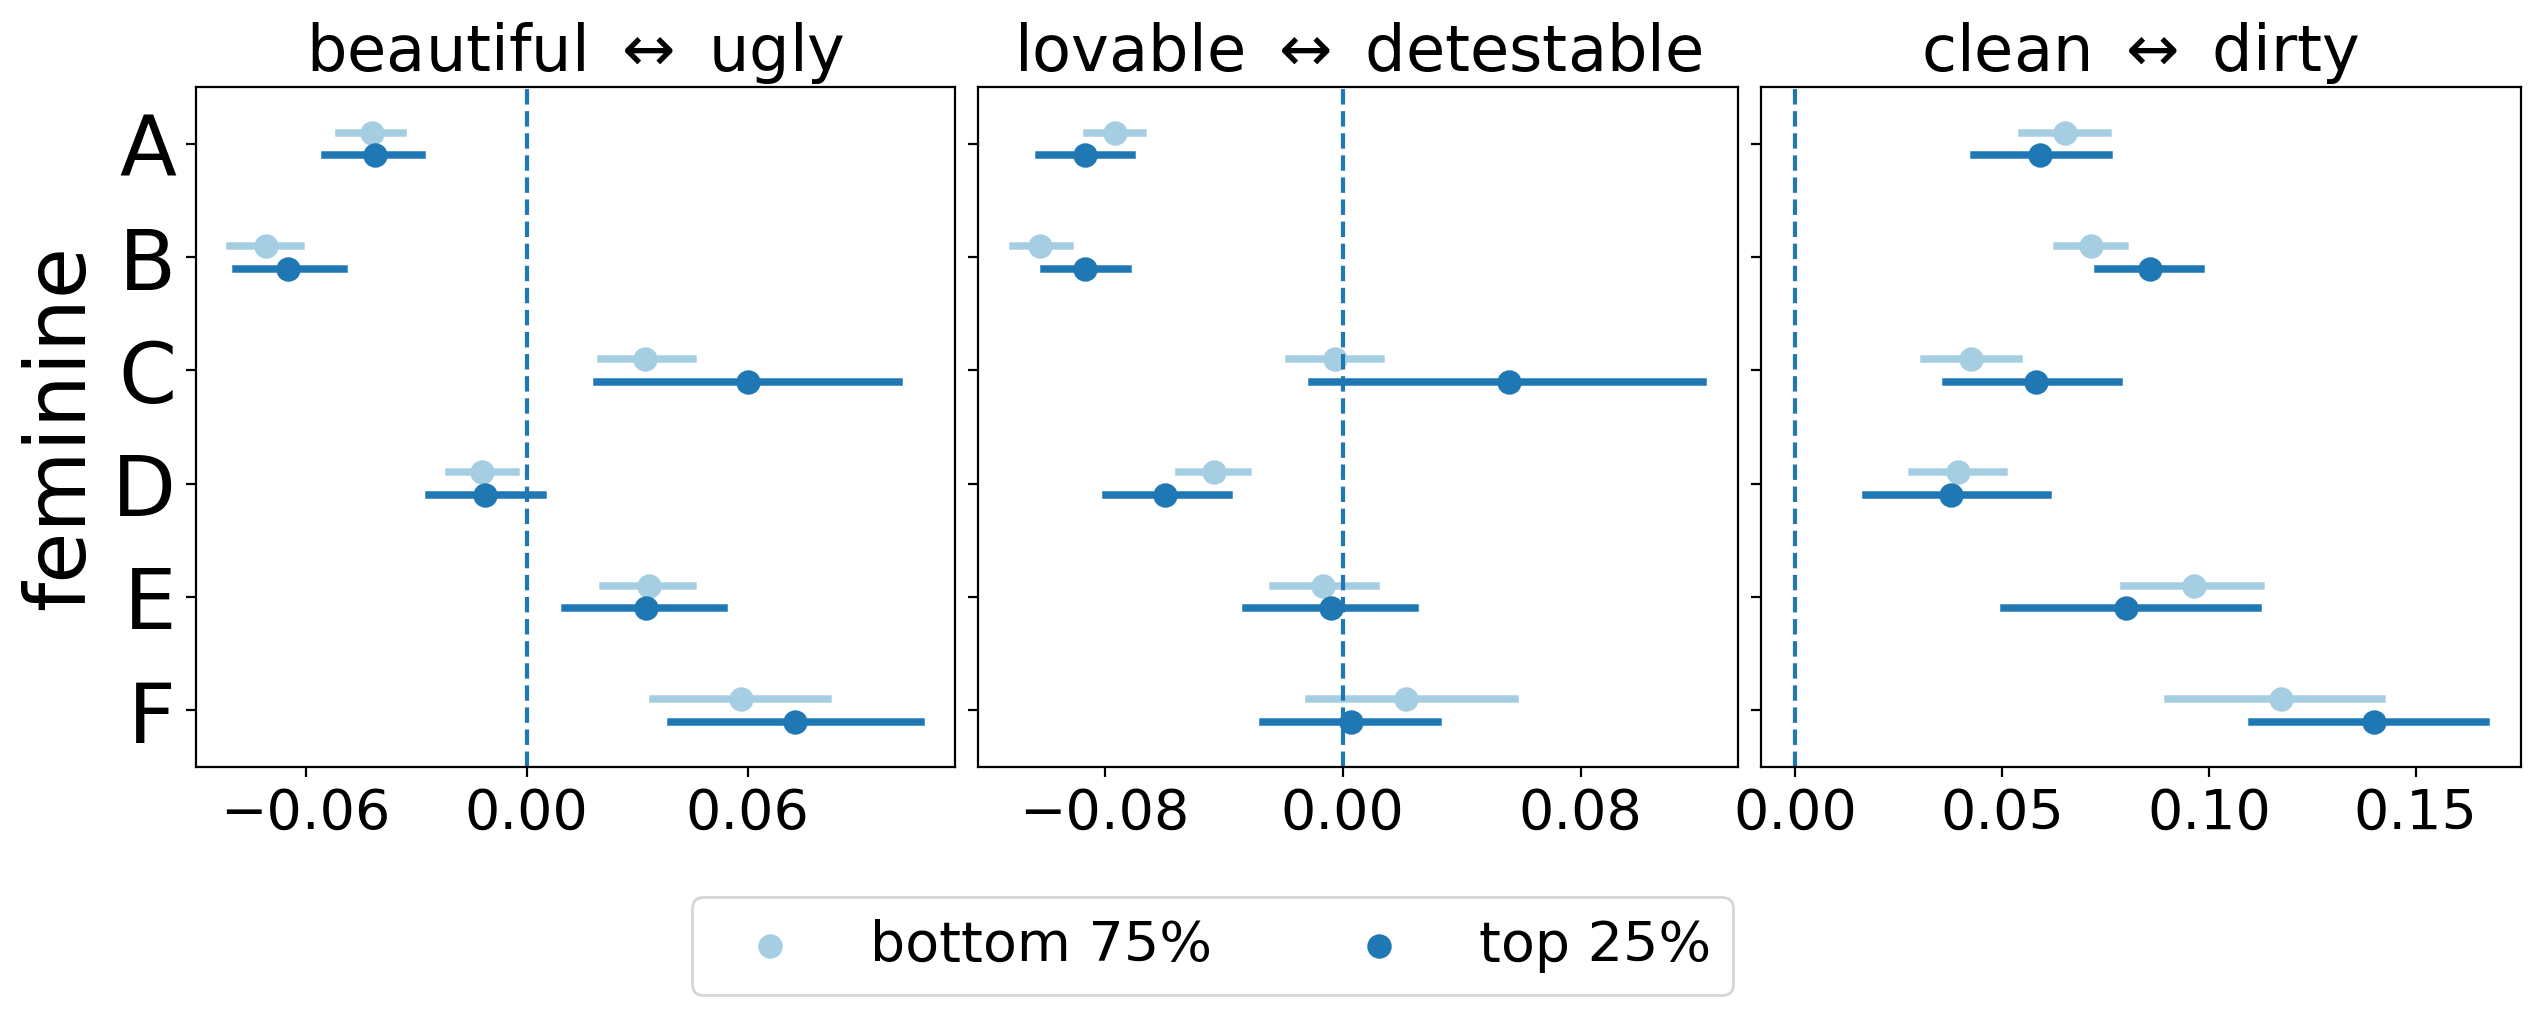

In [1071]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), dpi=200, sharey=True)
for order, pole in enumerate(fem_axes): 
    this_df = fem_cluster_score_df[fem_cluster_score_df['pole'] == pole]
    sns.pointplot(x="score", y="clust_letter", hue='freq_bucket', palette="Paired",
                  data=this_df, orient="h", dodge=.2, join=False, ax=axes[order])
    axes[order].axvline(0, linestyle='--')
    axes[order].set_title(pole_titles[pole], fontsize=23)
    axes[order].get_legend().remove()
    if order == 0: 
        axes[order].set_ylabel('feminine', fontsize=30)
    else: 
        axes[order].set_ylabel('')
    axes[order].set_xlabel('')
    axes[order].yaxis.set_tick_params(labelsize=30)
    axes[order].xaxis.set_major_locator(mtick.MaxNLocator(4))
    axes[order].xaxis.set_tick_params(labelsize=20)
plt.subplots_adjust(wspace=0.03, hspace=0)
plt.legend(fontsize=20, bbox_to_anchor=(0.0, -0.15), ncol=2)
plt.show()

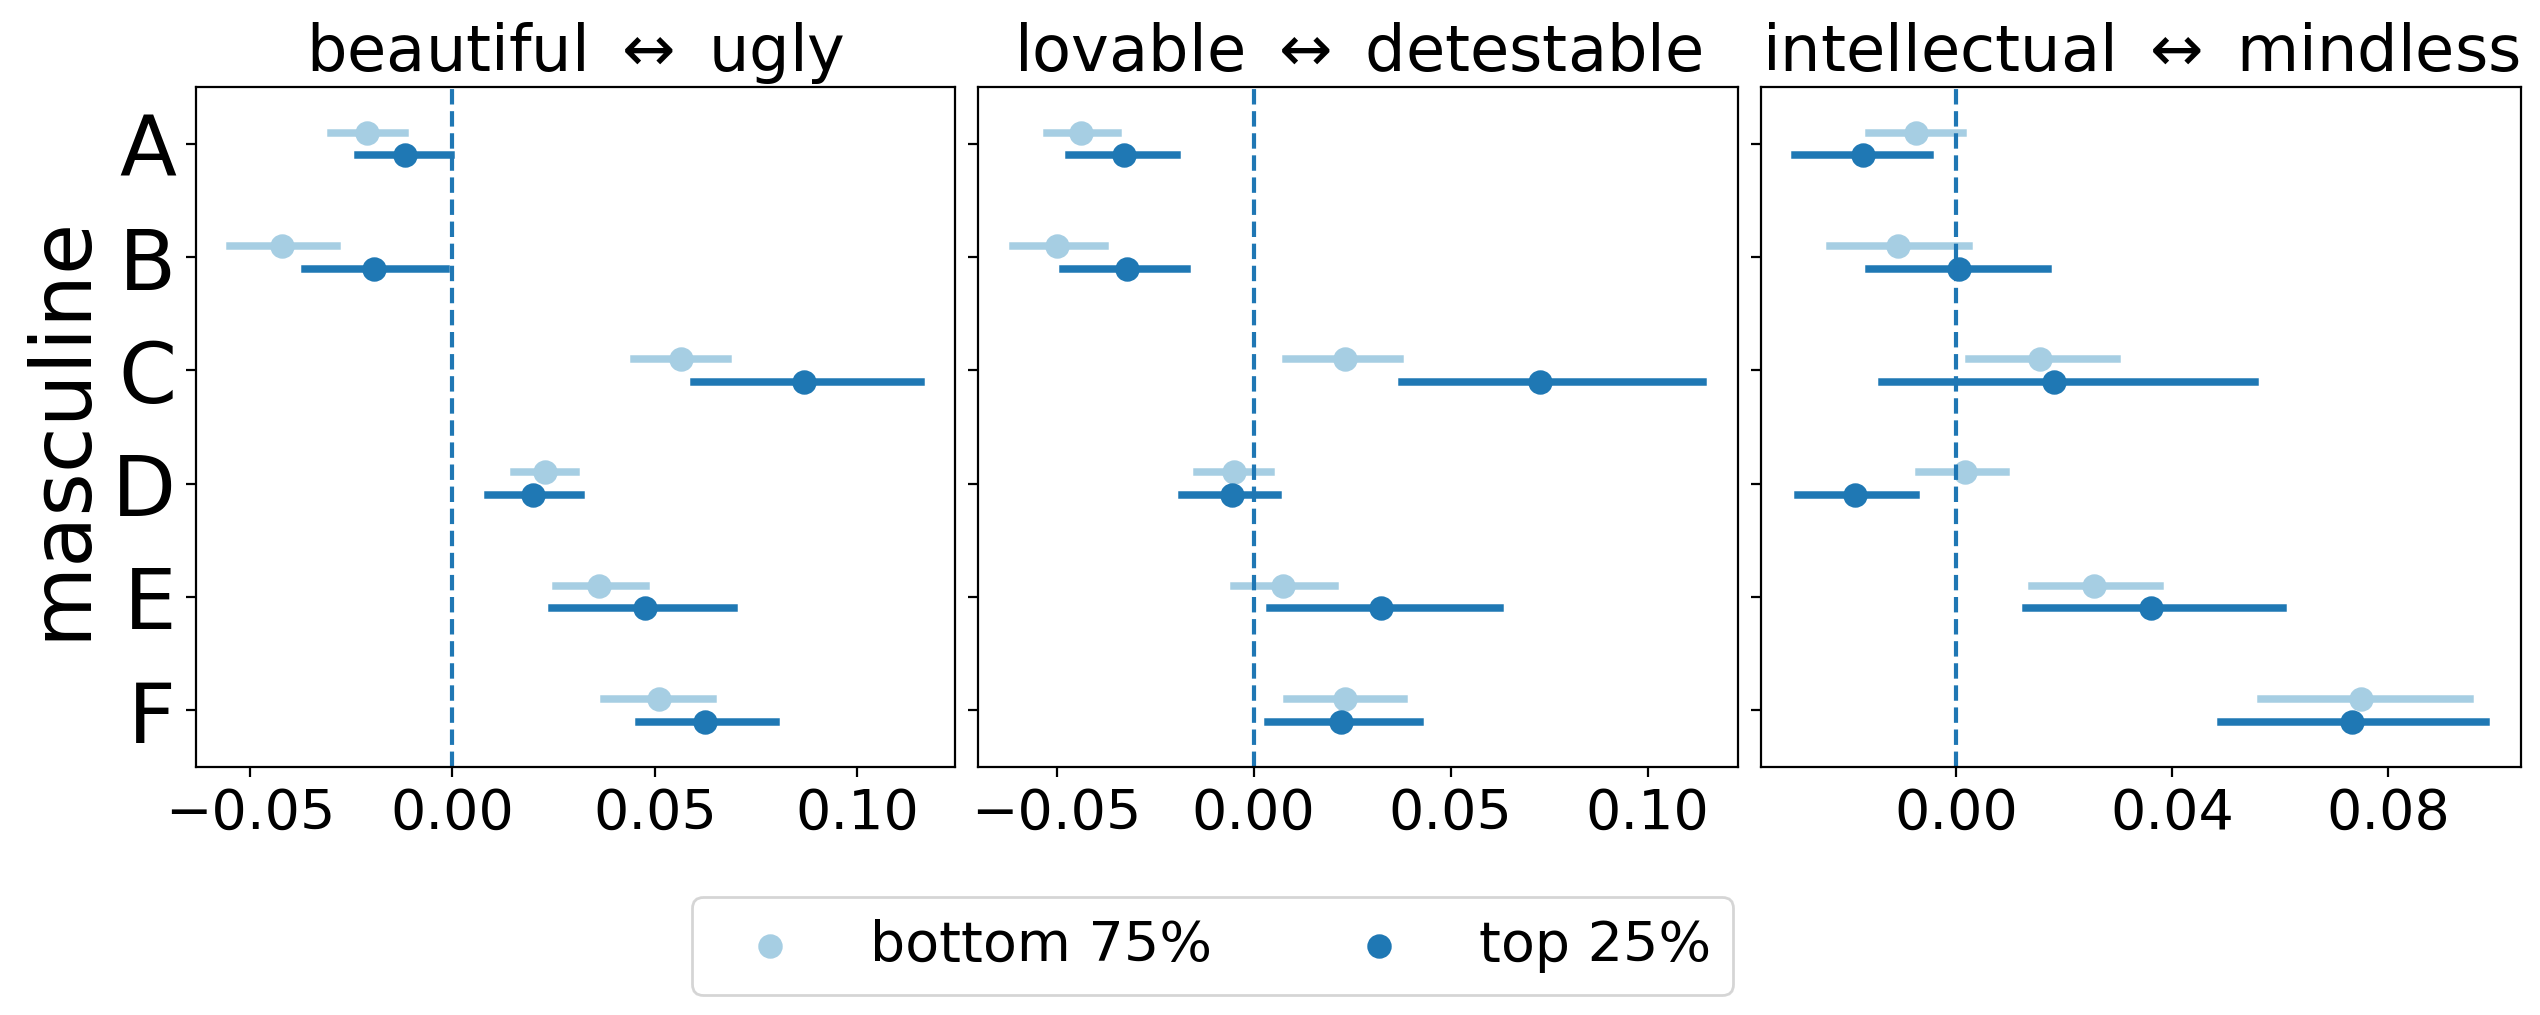

In [974]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), dpi=200, sharey=True)
for order, pole in enumerate(masc_axes): 
    this_df = masc_cluster_score_df[masc_cluster_score_df['pole'] == pole]
    sns.pointplot(x="score", y="clust_letter", hue='freq_bucket', palette="Paired",
                  data=this_df, orient="h", dodge=.2, join=False, ax=axes[order])
    axes[order].axvline(0, linestyle='--')
    axes[order].set_title(pole_titles[pole], fontsize=23)
    axes[order].get_legend().remove()
    if order == 0: 
        axes[order].set_ylabel('masculine', fontsize=30)
    else: 
        axes[order].set_ylabel('')
    axes[order].set_xlabel('')
    axes[order].yaxis.set_tick_params(labelsize=30)
    axes[order].xaxis.set_major_locator(mtick.MaxNLocator(4))
    axes[order].xaxis.set_tick_params(labelsize=20)
plt.subplots_adjust(wspace=0.03, hspace=0)
plt.legend(fontsize=20, bbox_to_anchor=(0.0, -0.15), ncol=2)
plt.show()

## Variants

moids vs. men

femoids, foids, vs. women

In [7]:
VARIANT_OUT = LOGS + 'semantics_mano/variant_scores/'

In [8]:
with open(VARIANT_OUT + 'scores.json', 'r') as infile: 
    variant_scores = json.load(infile)
pole_order = []
with open(VARIANT_OUT + 'pole_order.txt', 'r') as infile: 
    for line in infile:
        pole_order.append(line.strip())

In [977]:
scores_per_word = defaultdict(list)
for key in variant_scores:
    contents = key.split('_')
    if int(contents[-1]) not in [2017, 2018, 2019]: continue
    community = '_'.join(contents[1:len(contents)-1])
    if contents[0] in ['moids', 'men']: 
        gender = 'm'
    elif contents[0] in ['femoids', 'foids', 'women']: 
        gender = 'f'
    # women talking about men or men talking about women
    if (community.startswith('Femcels') or community.startswith('FDS')) and gender == 'f': continue
    if gender == 'm' and not (community.startswith('Femcels') or community.startswith('FDS')): continue
    scores_per_word[contents[0]].extend(variant_scores[key])
for w in scores_per_word: 
    scores_per_word[w] = np.array(scores_per_word[w])
    print(w, scores_per_word[w].shape)
comparisons = [('men', 'moids'), ('women', 'femoids'), ('women', 'foids')]

women (3618, 512)
femoids (853, 512)
foids (674, 512)
men (300, 512)
moids (300, 512)


In [912]:
for comp in comparisons: 
    print(comp)
    class1 = comp[0]
    class2 = comp[1]
    mean_diff = abs(np.mean(scores_per_word[class1], axis=0) - np.mean(scores_per_word[class2], axis=0))
    ind = np.argpartition(mean_diff, -10)[-10:]
    for idx in ind: 
        print(pole_order[idx],)
    print()

('men', 'moids')
wholesome.a.01
good.a.03
clearheaded.a.01
useful.a.01
dignified.a.01
defiant.a.01
exterior.a.01
meaningful.a.01
rational.a.01
inclined.a.01

('women', 'femoids')
trustful.a.01
meaningful.a.01
dignified.a.01
perfect.a.01
wholesome.a.01
lost.a.03
good.a.03
abstemious.a.01
shapely.a.01
rational.a.01

('women', 'foids')
empirical.a.01
wholesome.a.01
trustful.a.01
same.a.01
shapely.a.01
exterior.a.01
meaningful.a.01
rational.a.01
anterior.a.01
abstemious.a.01



In [978]:
# use axes to classify the identity of the word to find out which axes are important for distinguishing them
feat_importances = []
for comp in comparisons: 
    print("running model for", comp)
    class1 = comp[0]
    class2 = comp[1]
    y1 = [0]*scores_per_word[class1].shape[0]
    y2 = [1]*scores_per_word[class2].shape[0]
    y = np.array(y1 + y2)
    X = np.concatenate((scores_per_word[class1], scores_per_word[class2]), axis=0)
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X, y)
    feat_importances.append(forest.feature_importances_)

running model for ('men', 'moids')
running model for ('women', 'femoids')
running model for ('women', 'foids')


In [979]:
for i, comp in enumerate(comparisons): 
    print(comp)
    importances = feat_importances[i]
    ind = np.argpartition(importances, -10)[-10:]
    for idx in ind: 
        print(pole_order[idx],)
    print()

('men', 'moids')
custom-made.a.01
good.a.03
moral.a.01
violent.a.01
meaningful.a.01
useful.a.01
major.a.01
womanly.a.01
empirical.a.01
wholesome.a.01

('women', 'femoids')
beautiful.a.01
major.a.01
wholesome.a.01
meaningful.a.01
lost.a.03
shapely.a.01
clearheaded.a.01
pleasant.a.01
good.a.03
dignified.a.01

('women', 'foids')
dignified.a.01
high.a.04
good.a.03
blond.a.01
shapely.a.01
pleasant.a.01
mobile.a.02
empirical.a.01
meaningful.a.01
abstemious.a.01



In [1041]:
d = {
    'pole': [], # each row
    'gender': [], # two facets
    'year': [], # x axis
    'community': [],
    'word': [], # hue 
    'score': [], # y axis
}
poles_of_interest = ['good.a.03', 'dignified.a.01', 'wholesome.a.01']
for key in variant_scores:
    contents = key.split('_')
    for pole in poles_of_interest: 
        idx = pole_order.index(pole)
        for score_list in variant_scores[key]: 
            if int(contents[-1]) not in [2017, 2018, 2019]: continue
            community = '_'.join(contents[1:len(contents)-1])
            if contents[0] in ['moids', 'men']: 
                gender = 'm'
            elif contents[0] in ['femoids', 'foids', 'women']: 
                gender = 'f'
            # women talking about men or men talking about women
            if (community.startswith('Femcels') or community.startswith('FDS')) and gender == 'f': continue
            if gender == 'm' and not (community.startswith('Femcels') or community.startswith('FDS')): continue
            d['community'].append(community)
            score = score_list[idx]
            d['pole'].append(pole)
            d['word'].append(contents[0])
            d['gender'].append(gender)
            d['year'].append(int(contents[-1]))
            d['score'].append(score)
variant_df = pd.DataFrame.from_dict(d)

In [1042]:
variant_df

,pole,gender,year,community,word,score
0,good.a.03,f,2017,red_pill_talk,women,0.034638
1,good.a.03,f,2017,red_pill_talk,women,0.019909
2,good.a.03,f,2017,red_pill_talk,women,0.031381
3,good.a.03,f,2017,red_pill_talk,women,-0.022611
4,good.a.03,f,2017,red_pill_talk,women,0.040212
...,...,...,...,...,...,...
17230,wholesome.a.01,f,2017,the_attraction,women,-0.003068
17231,wholesome.a.01,f,2017,the_attraction,women,-0.007370
17232,wholesome.a.01,f,2017,the_attraction,women,0.000058
17233,wholesome.a.01,f,2017,the_attraction,women,-0.011523


In [1047]:
colors = [sns.color_palette("Paired")[1], 
            sns.color_palette("Paired")[0], 
            sns.color_palette("Paired")[0], 
            sns.color_palette("Paired")[3], 
            sns.color_palette("Paired")[2]
         ]

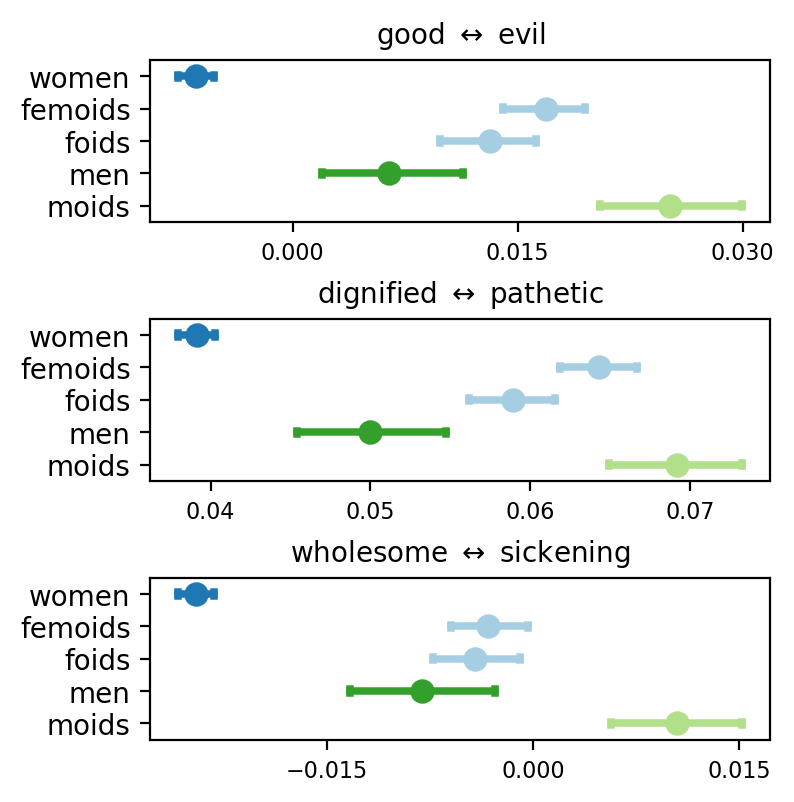

In [1070]:
fig, axes = plt.subplots(len(poles_of_interest), figsize=(4, 1.5*len(poles_of_interest)), dpi=200)
hue_order = ['women', 'foids', 'femoids', 'men', 'moids']

for i, pole in enumerate(poles_of_interest): 
    this_df = variant_df[variant_df['pole'] == poles_of_interest[i]]
    sns.pointplot(data=this_df, x='score', y='word', hue='word', hue_order=hue_order,
                  capsize=.1, palette=colors, ax=axes[i])
    axes[i].get_legend().remove()
    axes[i].set_ylabel('')
    axes[i].set_title(pole_titles[poles_of_interest[i]], fontsize=10)
    axes[i].set_xlabel('')
    axes[i].yaxis.set_tick_params(labelsize=10)
    axes[i].xaxis.set_major_locator(mtick.MaxNLocator(4))
    axes[i].xaxis.set_tick_params(labelsize=8)

plt.subplots_adjust(wspace=0, hspace=0.6)
#plt.legend(fontsize=15, bbox_to_anchor=(1, -0.8), ncol=2)
plt.show()

## Women across domains

In [3]:
WOMEN_OUT = LOGS + 'semantics_mano/women_scores/'

In [4]:
with open(WOMEN_OUT + 'True_scores.json', 'r') as infile: 
    person_women_scores = json.load(infile)
with open(WOMEN_OUT + 'False_scores.json', 'r') as infile: 
    self_women_scores = json.load(infile)

In [10]:
comparisons = [('feminists_wikipedia', 'feminists_extreme'), 
              ('girls_wikipedia', 'girls_extreme'), 
              ('women_wikipedia', 'women_extreme'), 
              ('females_wikipedia', 'females_extreme')]
for comp in comparisons: 
    print(comp)
    class1 = comp[0]
    class2 = comp[1]
    class1_scores = np.mean(self_women_scores[class1], axis=0)
    class2_scores = np.mean(self_women_scores[class2], axis=0)
    mean_diff = abs(class1_scores-class2_scores)
    ind = np.argpartition(mean_diff, -10)[-10:]
    for idx in ind: 
        print(pole_order[idx], round(class1_scores[idx],3), round(class2_scores[idx],3))
    print()

('feminists_wikipedia', 'feminists_extreme')
dignified.a.01 0.041 0.085
capitalistic.a.01 0.11 0.066
worthy.a.01 0.031 0.077
tasteful.a.01 -0.107 -0.061
thoughtful.a.02 0.007 0.057
original.a.03 -0.033 0.032
credulous.a.01 0.06 0.009
active.a.03 -0.208 -0.148
busy.a.01 0.0 0.057
concerned.a.01 -0.024 0.027

('girls_wikipedia', 'girls_extreme')
potent.a.03 0.011 -0.036
physical.a.01 -0.0 -0.049
selfish.a.01 -0.042 -0.094
dominant.a.01 0.037 -0.026
ordinary.a.01 0.006 -0.046
offensive.a.02 0.03 -0.032
rich.a.01 0.065 -0.011
persuasive.a.01 0.043 -0.01
worldly.a.01 0.067 -0.001
indulgent.a.01 -0.054 -0.103

('women_wikipedia', 'women_extreme')
ordinary.a.01 0.015 -0.039
persuasive.a.01 -0.013 -0.068
dominant.a.01 0.044 -0.021
active.a.03 -0.003 0.055
indulgent.a.01 -0.072 -0.136
selfish.a.01 -0.034 -0.097
offensive.a.02 0.036 -0.026
capitalistic.a.01 -0.04 -0.099
worldly.a.01 0.015 -0.052
dependent.a.01 0.012 -0.045

('females_wikipedia', 'females_extreme')
shod.a.01 0.015 0.105
selfish.a

In [80]:
d = {
    'pole': [], # each row
    'community': [],
    'word': [], # hue 
    'score': [], # y axis
    'identity': [], 
}
poles_of_interest = ['humane.a.02', 'lovable.a.01']
for key in self_women_scores:
    contents = key.split('_')
    for pole in poles_of_interest: 
        idx = pole_order.index(pole)
        community = contents[-1]
        if community == 'control': 
            community = 'reddit_other'
        if community == 'extreme': 
            community = 'extreme_rel'
        for score_list in self_women_scores[key]: 
            d['community'].append(community)
            score = score_list[idx]
            d['pole'].append(pole)
            d['word'].append(contents[0])
            d['score'].append(score)
            d['identity'].append('self')
        for score_list in person_women_scores[key]: 
            d['community'].append(community)
            score = score_list[idx]
            d['pole'].append(pole)
            d['word'].append(contents[0])
            d['score'].append(score)
            d['identity'].append('person')
women_df = pd.DataFrame.from_dict(d)

In [84]:
women_df

,pole,community,word,score,identity
0,humane.a.02,wikipedia,feminists,-0.239540,self
1,humane.a.02,wikipedia,feminists,-0.224537,self
2,humane.a.02,wikipedia,feminists,-0.137047,self
3,humane.a.02,wikipedia,feminists,-0.175914,self
4,humane.a.02,wikipedia,feminists,-0.196091,self
...,...,...,...,...,...
48063,lovable.a.01,extreme_rel,feminists,0.079165,person
48064,lovable.a.01,extreme_rel,feminists,-0.013309,person
48065,lovable.a.01,extreme_rel,feminists,-0.033473,person
48066,lovable.a.01,extreme_rel,feminists,0.004243,person


In [81]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

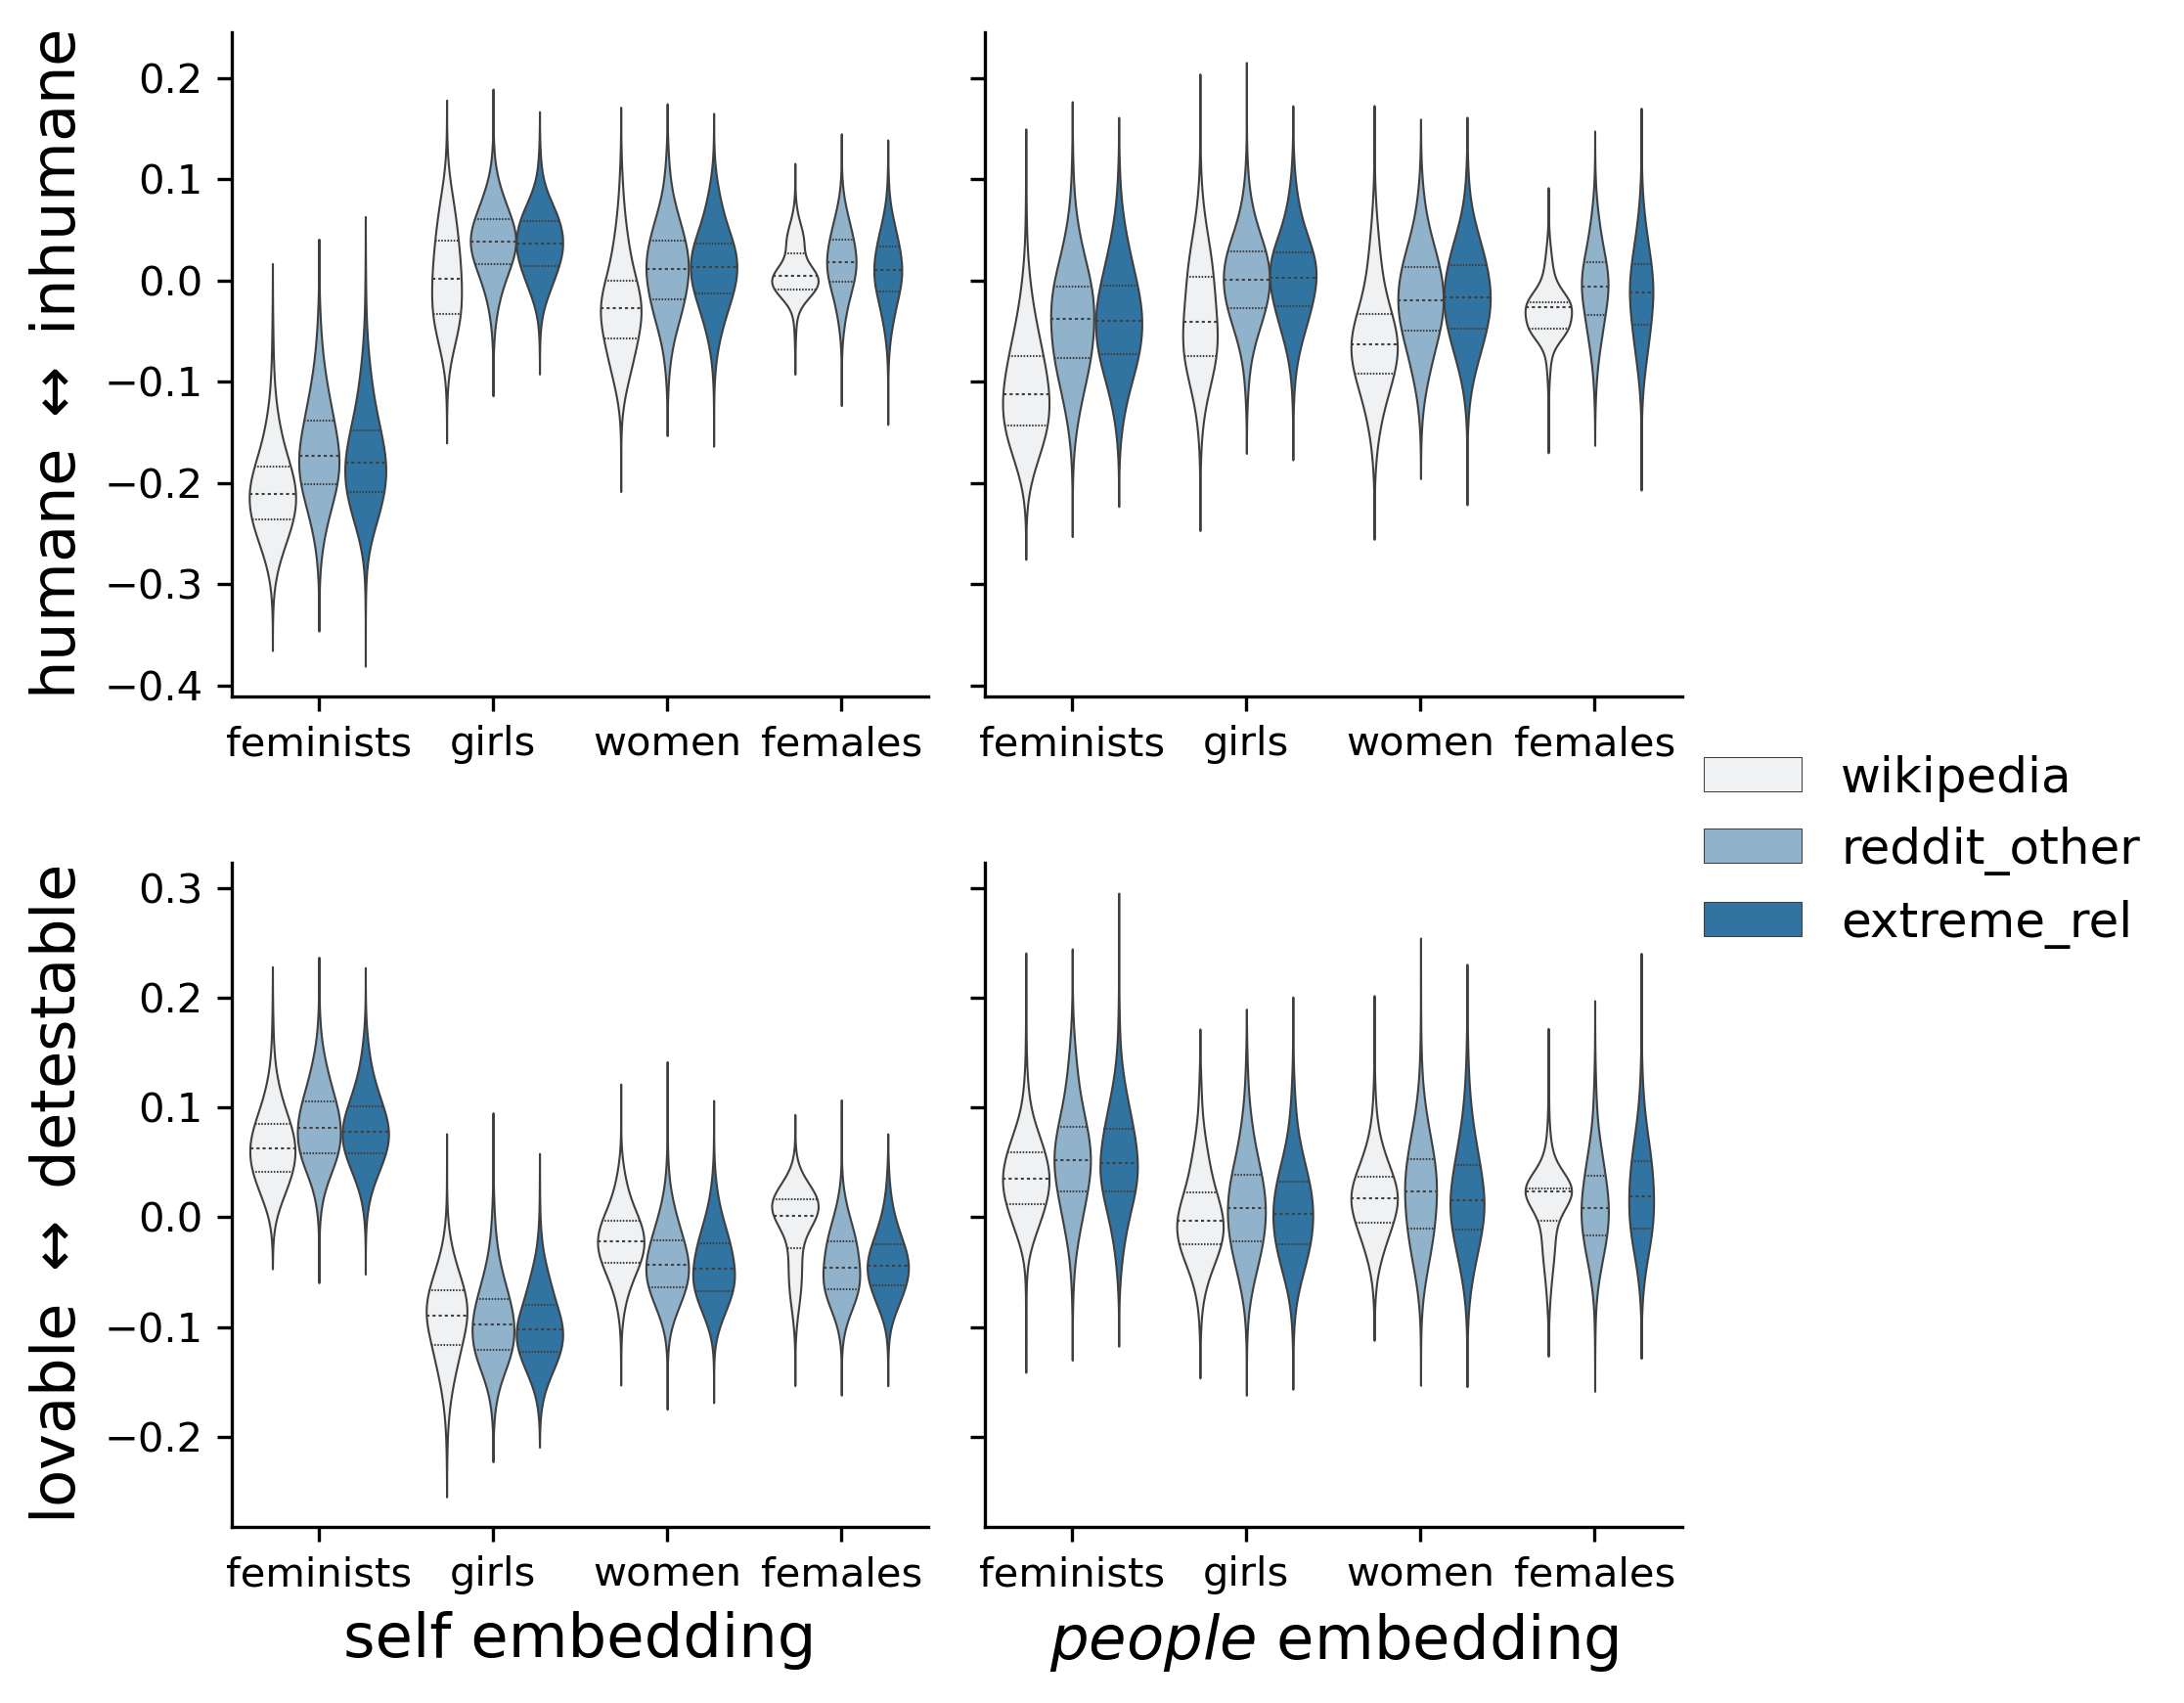

In [101]:
g = sns.FacetGrid(women_df, col="identity", row="pole", margin_titles=False, 
                  sharey="row", sharex=False)
# g.map_dataframe(sns.pointplot, x='word', y='score', hue='community', join=False, 
#                 dodge=0.3, palette=sns.color_palette("colorblind"), markers='.')
g.map_dataframe(sns.violinplot, x='word', y='score', hue='community', 
                inner="quartile", bw=0.5, linewidth=0.5)
g.axes[0, 0].set_ylabel(pole_titles[poles_of_interest[0]], fontsize=15)
g.axes[1, 0].set_ylabel(pole_titles[poles_of_interest[1]], fontsize=15)
g.axes[1, 0].set_xlabel('self embedding', fontsize=15)
g.axes[1, 1].set_xlabel('$\it{people}$ embedding', fontsize=15)
g.set_titles('')
if i == len(poles_of_interest) - 1: 
    g.add_legend(fontsize=12)
plt.show()

## Women over time

In [102]:
with open(WOMEN_OUT + 'True_time_scores.json', 'r') as infile: 
    time_women_scores = json.load(infile)

In [126]:
d = {
    'pole': [], 
    'dataset': [],
    'score': [], 
    'month': [], 
    'line_num': [],
    'replacement': [],
}
poles_of_interest = ['beautiful.a.01', 'lovable.a.01', 'clean.a.01']
for key in time_women_scores: 
    contents = key.split('_')
    if contents[2] == 'None-None' or contents[2] == '1970-01': continue # missing/incorrect dates
    for pole in poles_of_interest: 
        idx = pole_order.index(pole)
        for score_list in time_women_scores[key]: 
            score = score_list[idx]
            d['dataset'].append(contents[1])
            month = contents[2]
            month = dt.datetime.strptime(month,'%Y-%m').date()
            d['month'].append(month)
            d['replacement'].append(contents[3])
            d['line_num'].append(contents[4])
            d['pole'].append(pole)
            d['score'].append(score)
time_women_df = pd.DataFrame.from_dict(d)

In [127]:
time_women_df

,pole,dataset,score,month,line_num,replacement
0,beautiful.a.01,control,-0.058007,2011-07-01,58285,person
1,lovable.a.01,control,-0.066266,2011-07-01,58285,person
2,clean.a.01,control,-0.001839,2011-07-01,58285,person
3,beautiful.a.01,control,0.019085,2011-07-01,36533,person
4,lovable.a.01,control,0.019501,2011-07-01,36533,person
...,...,...,...,...,...,...
980218,lovable.a.01,extreme,-0.017575,2007-06-01,13139,person
980219,clean.a.01,extreme,0.011103,2007-06-01,13139,person
980220,beautiful.a.01,extreme,0.001288,2005-11-01,13139,person
980221,lovable.a.01,extreme,-0.009579,2005-11-01,13139,person


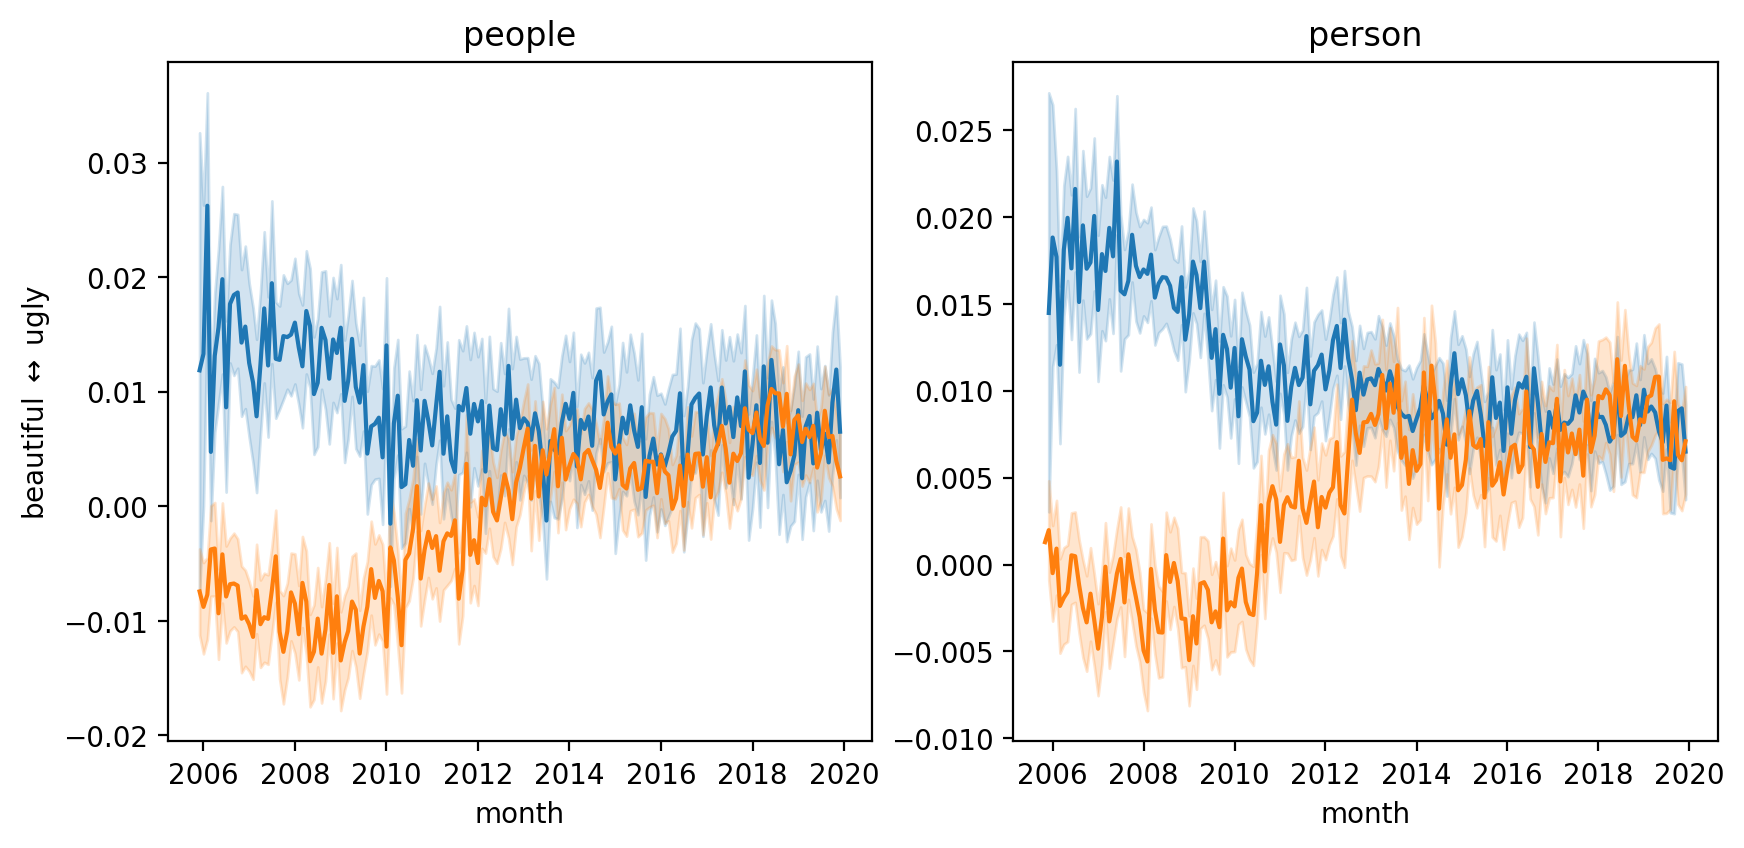

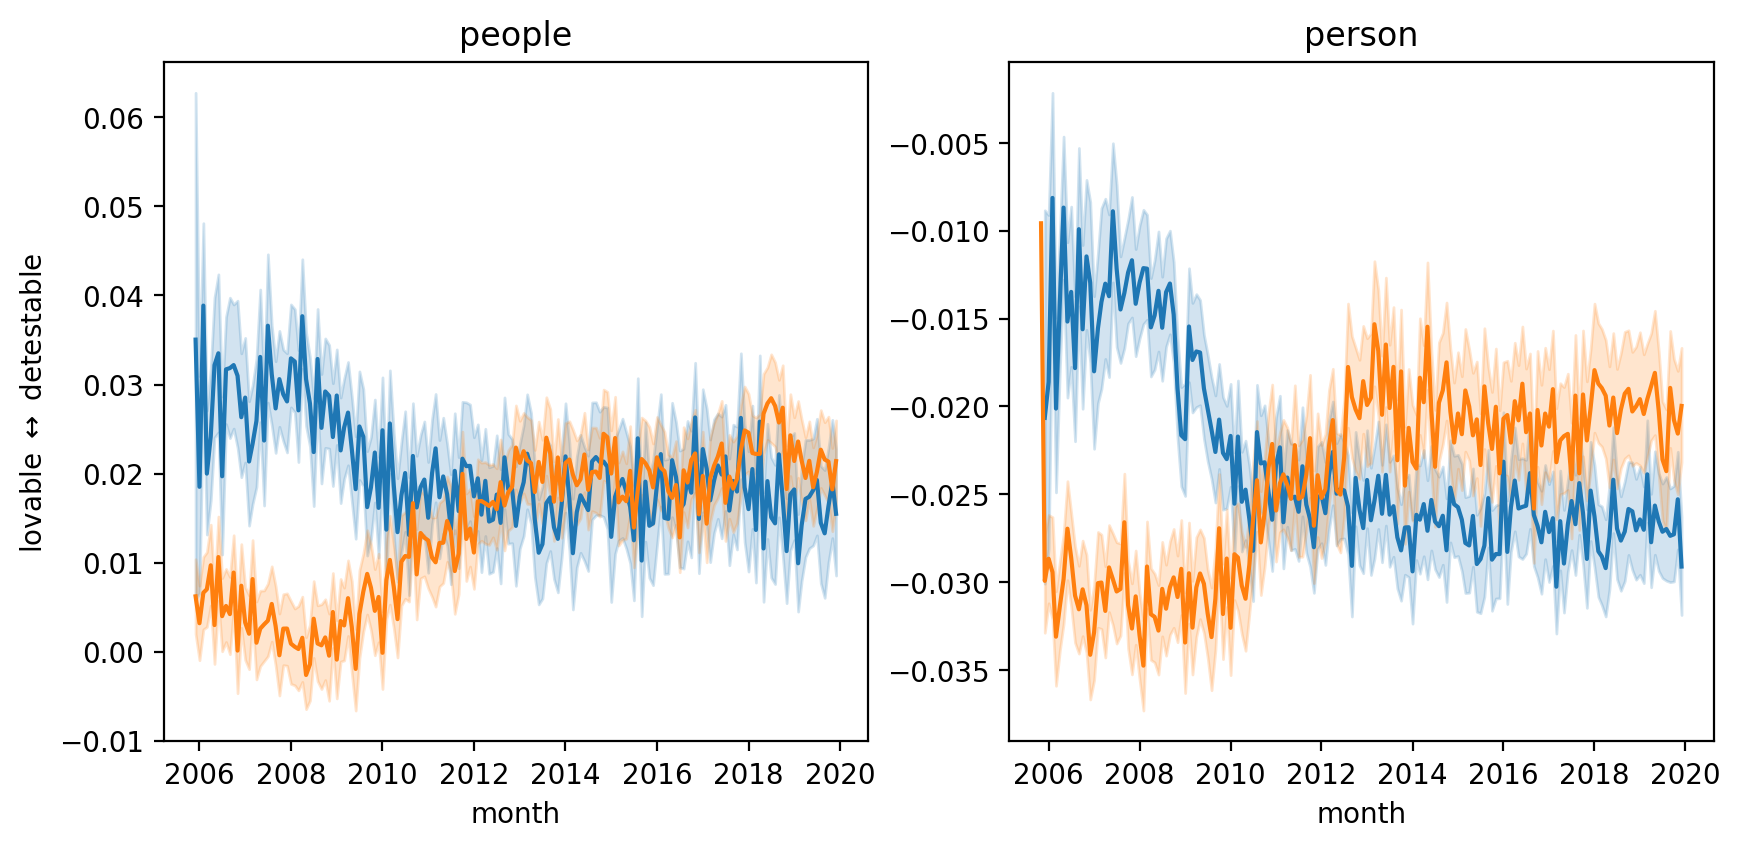

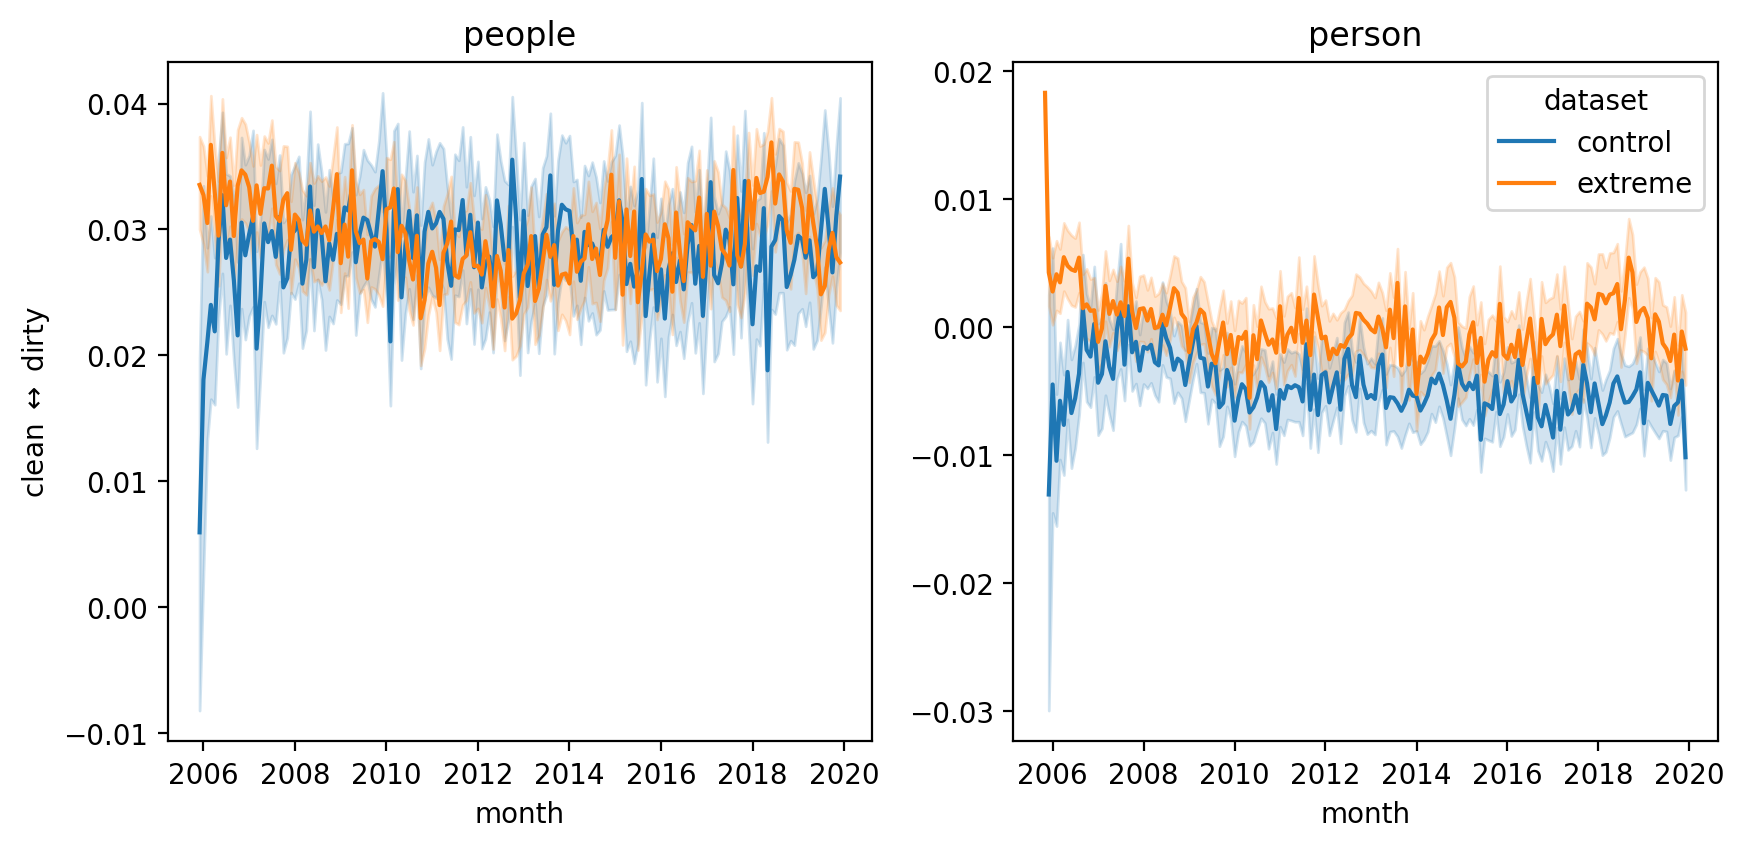

In [128]:
for i, pole in enumerate(poles_of_interest): 
    this_df = time_women_df[time_women_df['pole'] == pole]
    time_group_df = this_df[this_df['replacement'] == 'people']
    time_indiv_df = this_df[this_df['replacement'] == 'person']
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=200)
    sns.lineplot(data=time_group_df, x="month", y="score", hue="dataset", ax=axes[0])
    axes[0].set_ylabel(pole_titles[pole])
    axes[0].set_title('people')
    axes[0].get_legend().remove()
    sns.lineplot(data=time_indiv_df, x="month", y="score", hue="dataset", ax=axes[1])
    axes[1].set_ylabel('')
    axes[1].set_title('person')
    if i != len(poles_of_interest) - 1: 
        axes[1].get_legend().remove()
    plt.show()

In [137]:
this_df = time_women_df[time_women_df['pole'] == 'beautiful.a.01']
this_df = this_df[this_df['dataset'] == 'control']
this_df = this_df[this_df['month'] == dt.datetime.strptime('2007-04','%Y-%m').date()]
this_df.sort_values(by=['score'])

,pole,dataset,score,month,line_num,replacement
411201,beautiful.a.01,control,-0.127642,2007-04-01,5034,person
411879,beautiful.a.01,control,-0.102075,2007-04-01,9518,person
411225,beautiful.a.01,control,-0.100734,2007-04-01,5236,person
410595,beautiful.a.01,control,-0.094455,2007-04-01,165,person
411336,beautiful.a.01,control,-0.090098,2007-04-01,5953,people
...,...,...,...,...,...,...
410772,beautiful.a.01,control,0.123216,2007-04-01,1330,person
410952,beautiful.a.01,control,0.127263,2007-04-01,2868,person
411735,beautiful.a.01,control,0.141213,2007-04-01,8472,person
411183,beautiful.a.01,control,0.142992,2007-04-01,4811,person


In [139]:
this_df = time_women_df[time_women_df['pole'] == 'lovable.a.01']
this_df = this_df[this_df['dataset'] == 'control']
this_df = this_df[this_df['month'] == dt.datetime.strptime('2007-04','%Y-%m').date()]
this_df.sort_values(by=['score'])

,pole,dataset,score,month,line_num,replacement
411202,lovable.a.01,control,-0.120937,2007-04-01,5034,person
411412,lovable.a.01,control,-0.106577,2007-04-01,6554,person
411313,lovable.a.01,control,-0.104744,2007-04-01,5831,person
410983,lovable.a.01,control,-0.094233,2007-04-01,3380,person
411304,lovable.a.01,control,-0.088952,2007-04-01,5688,person
...,...,...,...,...,...,...
411832,lovable.a.01,control,0.105423,2007-04-01,9182,people
411592,lovable.a.01,control,0.108805,2007-04-01,7485,people
411448,lovable.a.01,control,0.126875,2007-04-01,6771,people
411709,lovable.a.01,control,0.128834,2007-04-01,8266,people


In [158]:
time_women_total = defaultdict(dict) # {dataset { month : score total} } 
time_women_count = defaultdict(Counter) # {dataset { month : count} } 
for key in time_women_scores: 
    contents = key.split('_')
    if contents[2] == 'None-None' or contents[2] == '1970-01': continue # missing/incorrect dates
    for score_list in time_women_scores[key]: 
        dataset = contents[1]
        month = contents[2]
        if contents[3] == 'people': continue # focus on person for now
        if month not in time_women_total[dataset]:
            time_women_total[dataset][month] = np.array(score_list) 
        else: 
            time_women_total[dataset][month] += np.array(score_list) 
        time_women_count[dataset][month] += 1
time_women_avg = defaultdict(dict)
for dataset in time_women_total: 
    for month in time_women_total[dataset]:
        time_women_avg[dataset][month] = time_women_total[dataset][month] / time_women_count[dataset][month]

In [159]:
def month_year_iter(start, end):
    '''
    https://stackoverflow.com/questions/5734438/how-to-create-a-month-iterator
    
    This function differs slightly from the one in lexical_change.py 
    because it converts the string to a datetime date. 
    '''
    start_contents = start.split('-')
    start_month = int(start_contents[1])
    start_year = int(start_contents[0])
    end_contents = end.split('-')
    end_month = int(end_contents[1])
    end_year = int(end_contents[0])
    ym_start= 12*start_year + start_month - 1
    ym_end= 12*end_year + end_month - 1
    for ym in range( ym_start, ym_end ):
        y, m = divmod( ym, 12 )
        month = str(m + 1)
        if len(month) == 1: 
            month = '0' + month
        str_month_year = str(y) + '-' + month
        yield str_month_year

In [162]:
min_month = '2005-11'
max_month = '2019-12'
months = list(month_year_iter(min_month, max_month))
m = []
for month in months: 
    m.append(time_women_avg['extreme'][month])
m = np.array(m)
pole_corr = Counter()
for i, pole in enumerate(pole_order): 
    pole_corr[pole] = stats.pearsonr(m[:,i], range(m.shape[0]))

In [163]:
print(pole_corr.most_common(10))
print(pole_corr.most_common()[-10::])

[('fresh.a.01', (0.9123408471968364, 1.1575324717232035e-66)), ('current.a.01', (0.8912349859885682, 3.1215840176032523e-59)), ('superior.a.01', (0.8895802643496389, 1.0255989007155313e-58)), ('happy.a.01', (0.8868732943493758, 6.895777931150634e-58)), ('future.a.01', (0.8771370310887623, 4.463394938021396e-55)), ('attractive.a.01', (0.8735246890388478, 4.2894765652429254e-54)), ('violent.a.01', (0.8568584399810153, 6.390964853942763e-50)), ('sound.a.03', (0.8552450350407372, 1.5181124609520325e-49)), ('robust.a.01', (0.8532029107194687, 4.470942539205547e-49)), ('heterogeneous.a.01', (0.8439983635942496, 4.784615828498965e-47))]
[('certain.a.02', (-0.8388208671744273, 5.814528333939352e-46)), ('formal.a.01', (-0.839771909442903, 3.699756486152502e-46)), ('free.a.02', (-0.8416241397310178, 1.5208117148941036e-46)), ('settled.a.01', (-0.8531437666990508, 4.611889420184181e-49)), ('long.a.01', (-0.8544338057045358, 2.3361931960583037e-49)), ('past.a.01', (-0.8581379376665946, 3.193756511

In [166]:
d = {
    'pole': [], 
    'dataset': [],
    'score': [], 
    'month': [], 
    'line_num': [],
    'replacement': [],
}
poles_of_interest = ['fresh.a.01', 'heavy.a.04', 'fat.a.01', 'good.a.03', 'dignified.a.01', 'wholesome.a.01']
for key in time_women_scores: 
    contents = key.split('_')
    if contents[2] == 'None-None' or contents[2] == '1970-01': continue # missing/incorrect dates
    for pole in poles_of_interest: 
        idx = pole_order.index(pole)
        for score_list in time_women_scores[key]: 
            score = score_list[idx]
            d['dataset'].append(contents[1])
            month = contents[2]
            month = dt.datetime.strptime(month,'%Y-%m').date()
            d['month'].append(month)
            d['replacement'].append(contents[3])
            d['line_num'].append(contents[4])
            d['pole'].append(pole)
            d['score'].append(score)
time_women_df = pd.DataFrame.from_dict(d)

In [ ]:
for i, pole in enumerate(poles_of_interest): 
    this_df = time_women_df[time_women_df['pole'] == pole]
    time_group_df = this_df[this_df['replacement'] == 'people']
    time_indiv_df = this_df[this_df['replacement'] == 'person']
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=200)
    sns.lineplot(data=time_group_df, x="month", y="score", hue="dataset", ax=axes[0])
    axes[0].set_ylabel(pole)
    axes[0].set_title('people')
    axes[0].get_legend().remove()
    sns.lineplot(data=time_indiv_df, x="month", y="score", hue="dataset", ax=axes[1])
    axes[1].set_ylabel('')
    axes[1].set_title('person')
    if i != len(poles_of_interest) - 1: 
        axes[1].get_legend().remove()
    plt.show()